<a href="https://colab.research.google.com/github/Cksdud123/colab/blob/main/NLPModel_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
import spacy
import string
import matplotlib.pyplot as plt
import warnings
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from tensorflow.keras.preprocessing.sequence import pad_sequences
warnings.filterwarnings('ignore')

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/archive_Twitter/twcs/twcs.csv", nrows=100000)

In [25]:
# 10만개의 데이터중 특정 데이터만 추출
df = df.sample(n=10000, replace=True)
df.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
66239,84094,133343,True,Thu Nov 30 13:35:21 +0000 2017,@Morrisons Thank you!,84093,77801.0
99590,125695,Walmart,False,Fri Nov 24 01:37:22 +0000 2017,@144198 You're ballin' with these jars! -Rad,NaN,125696.0
72090,93426,136243,True,Thu Nov 30 16:16:43 +0000 2017,@LondonMidland That would make sense as he was...,NaN,93425.0
72067,93397,136239,True,Thu Nov 30 15:25:15 +0000 2017,@116057 Postmates I was over charged for a tra...,93396,NaN
15860,20689,idea_cares,False,Wed Nov 01 07:02:29 +0000 2017,"@120521 As per our telecon, your issue has bee...",20690,20691.0


In [26]:
# 'author_id'와 'text' 열만 추출
sample_dataFrame = df[['author_id', 'text']]
sample_dataFrame.head(5)

,author_id,text
66239,133343,@Morrisons Thank you!
99590,Walmart,@144198 You're ballin' with these jars! -Rad
72090,136243,@LondonMidland That would make sense as he was...
72067,136239,@116057 Postmates I was over charged for a tra...
15860,idea_cares,"@120521 As per our telecon, your issue has bee..."


In [27]:
sample_dataFrame.shape

(10000, 2)

In [28]:
# 숫자만 있는지 확인하는 함수를 정의합니다.
def contains_only_digits(s):
    return bool(re.match("^[0-9]+$", s))

# 영어만 있는지 확인하는 함수를 정의합니다.
def contains_only_english(s):
    return bool(re.match("^[a-zA-Z]+$", s))

# 'author_id' 열에서 숫자만 있는 행들을 필터링하여 새로운 DataFrame을 만듭니다.
numbers_only_df = sample_dataFrame[sample_dataFrame['author_id'].apply(contains_only_digits)]

# 'author_id' 열에서 영어만 있는 행들을 필터링하여 새로운 DataFrame을 만듭니다.
english_only_df = sample_dataFrame[sample_dataFrame['author_id'].apply(contains_only_english)]

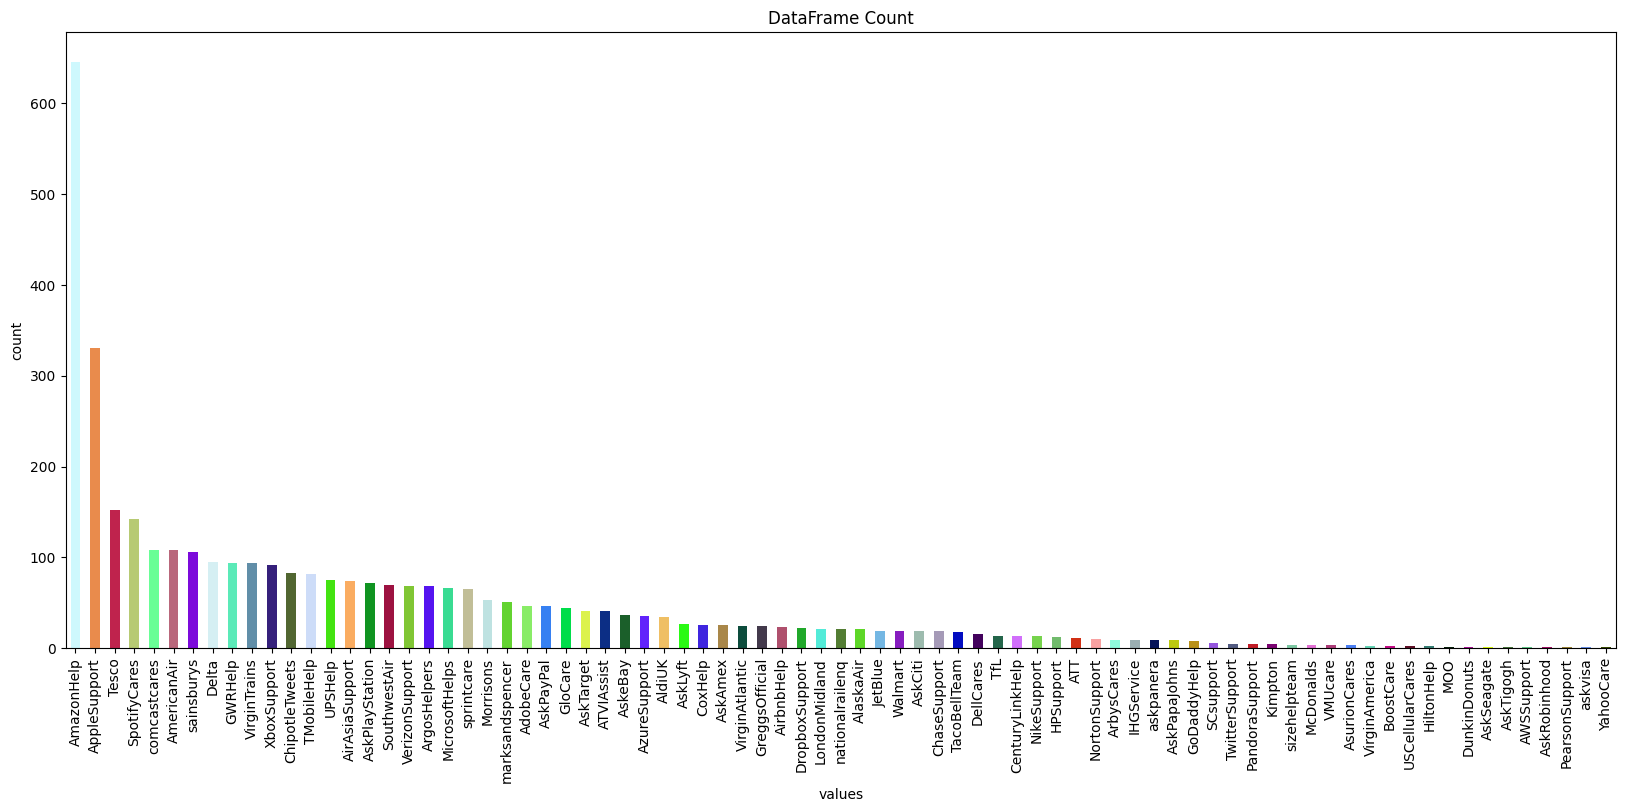

In [29]:
# 'author_id' 값들의 개수를 세어줍니다.
value_counts = english_only_df['author_id'].value_counts()

# 랜덤 색상을 생성합니다.
num_unique_values = len(value_counts)
colors = np.random.rand(num_unique_values, 3)

# 바 그래프를 생성합니다.
plt.figure(figsize=(20, 8))  # x축 크기를 늘립니다.
value_counts.plot(kind='bar', color=colors)
plt.xticks(rotation=90)  # x축 라벨을 세로로 회전시킵니다.
plt.xlabel('values')
plt.ylabel('count')
plt.title('DataFrame Count')
plt.show()

In [30]:
english_only_text_df = english_only_df[['author_id', 'text']]
english_only_text_df

,author_id,text
99590,Walmart,@144198 You're ballin' with these jars! -Rad
1080,CenturyLinkHelp,@116071 Please let us know if you have any que...
60519,AmazonHelp,"@132999 Hi, sorry to hear your having this iss..."
78241,TMobileHelp,@138054 Let's continue to work in DM to get th...
25384,Delta,"@123098 Hello, Bruce! *HCK"
...,...,...
17795,JetBlue,@121013 It looks like your TrueBlue account wa...
25108,TfL,"@123008 1/2 Hi Mark no, Contactless payment do..."
78065,AmericanAir,@138006 We're sorry that they're not working. ...
4038,ChipotleTweets,@116984 ¯\_(ツ)_/¯ -Becky


In [31]:
# 데이터 전처리 함수들
def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()

    # 구두점 제거
    punc_to_remove = string.punctuation
    text = text.translate(str.maketrans('', '', punc_to_remove))

    # 불용어 제거
    STOPWORDS = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in STOPWORDS])

    # 자주 사용하는 용어 제거
    cnt = Counter(text.split())
    FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
    text = " ".join([word for word in text.split() if word not in FREQWORDS])

    # 어간 추출
    stemmer = PorterStemmer()
    text = " ".join([stemmer.stem(word) for word in text.split()])

    # 표제어 추출
    lemmatizer = WordNetLemmatizer()
    pos_tagged_text = nltk.pos_tag(text.split())
    wordnet_map = {"N": wordnet.NOUN, "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}
    text = " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

    return text

# 'text' 열에 전처리 적용
numbers_only_df['text'] = numbers_only_df['text'].apply(preprocess_text)
english_only_df['text'] = english_only_df['text'].apply(preprocess_text)

In [32]:
# 토큰화 함수를 정의합니다.
def tokenize_text(text):
    return word_tokenize(text)

# 토큰화된 데이터를 저장할 새로운 열을 만들고, 토큰화를 수행합니다.
numbers_only_df['tokenized_text'] = numbers_only_df['text'].apply(tokenize_text)
# 토큰화된 데이터를 저장할 새로운 열을 만들고, 토큰화를 수행합니다.
english_only_df['tokenized_eng_text'] = english_only_df['text'].apply(tokenize_text)

In [33]:
numbers_only_df = numbers_only_df[['author_id','tokenized_text']]
numbers_only_df.head(5)

,author_id,tokenized_text
66239,133343,[]
72090,136243,[]
72067,136239,"[anyon, care, help, what, go]"
22984,122466,[]
43447,128277,[]


In [34]:
english_only_df = english_only_df[['author_id','tokenized_eng_text']]
english_only_df.head(5)

,author_id,tokenized_eng_text
99590,Walmart,[]
1080,CenturyLinkHelp,[lexi]
60519,AmazonHelp,"[delet, kindle]"
78241,TMobileHelp,"[httpstcocbacc4vqgh, michellewalk]"
25384,Delta,[]


In [35]:
# 'numbers_only_df'에서 빈 문자열과 '[]'를 결측치로 처리하고 제거합니다.
numbers_only_df = numbers_only_df.replace("", np.nan)
numbers_only_df = numbers_only_df.replace("[]", np.nan)
numbers_only_df = numbers_only_df.dropna()

# 'english_only_df'에서 빈 문자열과 '[]'를 결측치로 처리하고 제거합니다.
english_only_df = english_only_df.replace("", np.nan)
english_only_df = english_only_df.replace("[]", np.nan)
english_only_df = english_only_df.dropna()

In [36]:
# 결과 확인
numbers_only_df.head()

,author_id,tokenized_text
66239,133343,[]
72090,136243,[]
72067,136239,"[anyon, care, help, what, go]"
22984,122466,[]
43447,128277,[]


In [37]:
english_only_df.head()

,author_id,tokenized_eng_text
99590,Walmart,[]
1080,CenturyLinkHelp,[lexi]
60519,AmazonHelp,"[delet, kindle]"
78241,TMobileHelp,"[httpstcocbacc4vqgh, michellewalk]"
25384,Delta,[]


In [38]:
# 전체 데이터프레임의 토큰화된 텍스트 열 가져오기
tokens_list = numbers_only_df['tokenized_text'].tolist() + english_only_df['tokenized_eng_text'].tolist()

# 모든 토큰들을 하나의 리스트로 통합
all_tokens = [token for tokens in tokens_list for token in tokens]

# 토큰들의 빈도수를 계산하여 단어 집합 생성
word_counter_num = Counter(all_tokens)
word_vocab_num = {word: idx for idx, (word, _) in enumerate(word_counter_num.items())}

print(word_vocab_num)

{'anyon': 0, 'care': 1, 'help': 2, 'what': 3, 'go': 4, 'never': 5, 'miss': 6, 'payment': 7, 'im': 8, 'purchas': 9, 'premium': 10, 'packag': 11, 'there': 12, 'noth': 13, '5': 14, 'star': 15, 'feel': 16, 'cyber': 17, 'protect': 18, 'httpstconjhxtx9m4b': 19, 'charg': 20, 'reciev': 21, 'sinc': 22, 'octnov': 23, 'access': 24, 'xfiniti': 25, 'wifi': 26, 'applic': 27, 'take': 28, 'week': 29, 'complet': 30, 'due': 31, 'error': 32, 'comcast': 33, '’': 34, 'part': 35, 'final': 36, 'approv': 37, 'app': 38, 'itsalwayssometh': 39, 'actual': 40, 'dogshit': 41, 'trigger': 42, 'reboot': 43, '😊': 44, 'year': 45, 'get': 46, 'new': 47, 'one': 48, 'free': 49, 'song': 50, 'playlist': 51, 'plea': 52, 'tri': 53, 'later': 54, 'cool': 55, 'system': 56, 'guy': 57, 'sometim': 58, 'hous': 59, 'build': 60, 'mostli': 61, 'drive': 62, 'demo': 63, 'script': 64, 'gener': 65, 'fill': 66, '1': 67, 'liner': 68, '12': 69, 'peopl': 70, 'collect': 71, 'christma': 72, 'buy': 73, 'coupl': 74, 'extra': 75, 'bit': 76, 'donat': 

In [39]:
# 워드임베딩 실행
# 데이터셋의 토큰화된 텍스트 열 가져오기 (예시로 numbers_only_df의 tokenized_text 사용)
tokens_list_emb = numbers_only_df['tokenized_text'].tolist() + english_only_df['tokenized_eng_text'].tolist()

# Word2Vec 모델 학습
tokens_list_emb = numbers_only_df['tokenized_text'].tolist() + english_only_df['tokenized_eng_text'].tolist()
model_word2vec = Word2Vec(sentences=tokens_list_emb, vector_size=100, window=5, min_count=1, sg=1)

# Word2Vec 모델의 단어와 임베딩 벡터 매핑
word_vocab_num = {word: idx for idx, word in enumerate(model_word2vec.wv.index_to_key)}
word_embeddings = model_word2vec.wv.vectors

# 워드 임베딩 적용 결과 출력
print("Word Embeddings Shape:", word_embeddings.shape)

Word Embeddings Shape: (6826, 100)


In [40]:
word_embeddings

array([[-0.14576952,  0.23943476, -0.05455143, ..., -0.42054155,
         0.11547247, -0.03370919],
       [-0.09937453,  0.19865474, -0.05698823, ..., -0.26973537,
         0.05688853, -0.02389002],
       [-0.12169325,  0.22164433, -0.08462161, ..., -0.33456075,
         0.09837374, -0.04553564],
       ...,
       [ 0.002391  ,  0.00404408, -0.0082067 , ..., -0.01424375,
         0.01523307, -0.00327682],
       [ 0.0044166 ,  0.00518062, -0.00261098, ..., -0.01149835,
        -0.00849894,  0.00741936],
       [ 0.00104413,  0.00561702,  0.00232063, ..., -0.00503776,
         0.00884669,  0.00237372]], dtype=float32)

In [43]:
# 훈련셋과 검증셋 분리
X = numbers_only_df['tokenized_text'].tolist() + english_only_df['tokenized_eng_text'].tolist()
y = [0] * len(numbers_only_df) + [1] * len(english_only_df)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터를 정수 시퀀스로 변환
X_train = [[word_vocab_num[word] for word in tokens] for tokens in X_train]
X_val = [[word_vocab_num[word] for word in tokens] for tokens in X_val]

# 패딩 처리
max_sequence_length = max(len(seq) for seq in X_train + X_val)  # 최대 시퀀스 길이
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_sequence_length, padding='post')

# LSTM 모델 구성
embedding_dim = 100  # 임베딩 벡터의 차원
vocab_size = len(word_vocab_num)  # 단어 집합의 크기

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length, weights=[word_embeddings]))
model.add(LSTM(units=128))
model.add(Dense(units=1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 훈련
epochs = 10
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

ValueError: ignored